# Salary Prediction 

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting Job Salary.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling

## 1. Probelem Definition

Successful models will incorporate some analysis of the impact of including different keywords or phrases, as well as making use of the structured data fields like location, hours or company.  Some of the structured data shown (such as category) is 'inferred' by Adzuna's own processes, based on where an ad came from or its contents, and may not be "correct" but is representative of the real data.


You will be provided with a training data set on which to build your model, which will include all variables including salary. 


## 2. Data

The main dataset consists of a large number of rows representing individual job ads, and a series of fields about each job ad.  

### Location Tree

This is a supplemental data set that describes the hierarchical relationship between the different Normalised Locations shown in the job data.  It it is likely that there are meaningful relationships between the salaries of jobs in a similar geographical area, for example average salaries in London and the South East are higher than in the rest of the UK.


## 3. Evaluation

Our evaluation data set is simply a random subset of ads for which we know the salary, that were not included in the training and public testing datasets.

The evaluation metric for this competition is Mean Absolute Error

Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:

Have a header: "Id,SalaryNormalized"
Contain two columns
Id: Id for the ads in the validation set in sorted order
SalaryNormalized: Your predicted salary for the job ad

## 4. Features

These fields are as follows:

Id - A unique identifier for each job ad

Title - A freetext field supplied to us by the job advertiser as the Title of the job ad.  Normally this is a summary of the job title or role.

FullDescription - The full text of the job ad as provided by the job advertiser.  Where you see ***s, we have stripped values from the description in order to ensure that no salary information appears within the descriptions.  There may be some collateral damage here where we have also removed other numerics.

LocationRaw - The freetext location as provided by the job advertiser.

LocationNormalized - Adzuna's normalised location from within our own location tree, interpreted by us based on the raw location.  Our normaliser is not perfect!

ContractType - full_time or part_time, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

ContractTime - permanent or contract, interpreted by Adzuna from description or a specific additional field we received from the advertiser.

Company - the name of the employer as supplied to us by the job advertiser.

Category - which of 30 standard job categories this ad fits into, inferred in a very messy way based on the source the ad came from.  We know there is a lot of noise and error in this field.

SalaryRaw - the freetext salary field we received in the job advert from the advertiser.

SalaryNormalised - the annualised salary interpreted by Adzuna from the raw salary.  Note that this is always a single value based on the midpoint of any range found in the raw salary.  This is the value we are trying to predict.

SourceName - the name of the website or advertiser from whom we received the job advert. 

All of the data is real, live data used in job ads so is clearly subject to lots of real world noise, including but not limited to: ads that are not UK based, salaries that are incorrectly stated, fields that are incorrectly normalised and duplicate adverts.


In [24]:
#import required tools like below
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import os

In [25]:
#Download dataset from Kaggle
od.download('https://www.kaggle.com/c/job-salary-prediction')

Skipping, found downloaded files in ".\job-salary-prediction" (use force=True to force download)


In [26]:
os.listdir('job-salary-prediction')

['Location_Tree.csv',
 'mean_benchmark.csv',
 'random_forest_benchmark_test_rev1.csv',
 'test.csv',
 'Test_rev1',
 'Test_rev1.7z',
 'Test_rev1.zip',
 'Train_rev1.7z',
 'Train_rev1.zip',
 'Valid_rev1.7z',
 'Valid_rev1.csv']

In [27]:
#unzip Train_rev1.zip folder

from zipfile import ZipFile

file_name = "./job-salary-prediction/Train_rev1.zip"

In [28]:
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
Train_rev1.csv                                 2013-02-21 15:44:00    440631901
Extracting all the files now...
Done!


In [29]:
#load the data
dataset = pd.read_csv('Train_rev1.csv')

In [30]:
dataset.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [31]:
Info1 = pd.read_csv('./job-salary-prediction/Location_Tree.csv')

In [32]:
len(Info1)

31762

In [33]:
#Below method gives us data type of each column and non-null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [34]:
#checking for null values
dataset.isna().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [35]:
#Identifying Numeric Columns and String Columns
numeric_cols = dataset.select_dtypes(include=np.number).columns.tolist()
string_cols = ['Title', 'FullDescription', 'LocationRaw', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName']

In [36]:
print('Numeric Columns',numeric_cols)
print('String Columns', string_cols)

Numeric Columns ['Id', 'SalaryNormalized']
String Columns ['Title', 'FullDescription', 'LocationRaw', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName']


In [37]:
#Changing String columns to Category Columns
#dataset[string_cols] = dataset[string_cols].astype('category')

In [38]:
#Removing Salary Raw Column from dataset
dataset.drop('SalaryRaw',axis=1,inplace=True)

In [23]:
dataset.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000,cv-library.co.uk


In [40]:
#Chnaging String Columns to Category Columns
for label, content in dataset.items():
    if pd.api.types.is_string_dtype(content):
        dataset[label] = content.astype("category").cat.as_ordered()

In [41]:
dataset.dtypes

Id                       int64
Title                 category
FullDescription       category
LocationRaw           category
LocationNormalized    category
ContractType          category
ContractTime          category
Company               category
Category              category
SalaryNormalized         int64
SourceName            category
dtype: object

In [42]:
# Filling missing values
for label,content in dataset.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        dataset[label+"is_missing"]=pd.isnull(content)
        # Turn categories into numbers and add+1
        dataset[label] = pd.Categorical(content).codes+1

In [43]:
dataset.isna().sum()

Id                              0
Title                           0
FullDescription                 0
LocationRaw                     0
LocationNormalized              0
ContractType                    0
ContractTime                    0
Company                         0
Category                        0
SalaryNormalized                0
SourceName                      0
Titleis_missing                 0
FullDescriptionis_missing       0
LocationRawis_missing           0
LocationNormalizedis_missing    0
ContractTypeis_missing          0
ContractTimeis_missing          0
Companyis_missing               0
Categoryis_missing              0
SourceNameis_missing            0
dtype: int64

In [44]:
dataset.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SourceNameis_missing
0,12612628,39227,68301,5178,751,0,2,7758,9,25000,43,False,False,False,False,True,False,False,False,False
1,12612830,121388,196351,6881,987,0,2,7758,9,30000,43,False,False,False,False,True,False,False,False,False
2,12612844,73486,117824,7630,1069,0,2,7758,9,30000,43,False,False,False,False,True,False,False,False,False
3,12613049,39228,68300,17183,2310,0,2,7758,9,27500,43,False,False,False,False,True,False,False,False,False
4,12613647,85435,157839,17183,2310,0,2,7758,9,25000,43,False,False,False,False,True,False,False,False,False


In [195]:
dataset.corr()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SourceNameis_missing
Id,1.000000,-0.013694,-0.011799,0.018567,0.034221,-0.090582,0.155386,0.125477,0.037169,0.047091,0.110177,-0.013840,NaN,NaN,NaN,0.080275,-0.168408,-0.220759,NaN,0.001755
Title,-0.013694,1.000000,0.303746,-0.000020,-0.002829,-0.010841,0.019003,0.007846,0.066510,0.038887,0.019696,-0.003484,NaN,NaN,NaN,0.007189,-0.021411,0.002455,NaN,0.002130
FullDescription,-0.011799,0.303746,1.000000,-0.002114,-0.005580,0.028195,-0.014425,0.045818,0.004356,-0.007787,-0.010384,0.001332,NaN,NaN,NaN,-0.027814,0.013760,0.004359,NaN,-0.003477
LocationRaw,0.018567,-0.000020,-0.002114,1.000000,0.591206,-0.008495,0.003297,0.014012,0.032869,-0.013132,-0.024543,0.000017,NaN,NaN,NaN,0.011877,-0.001009,-0.006592,NaN,0.001818
LocationNormalized,0.034221,-0.002829,-0.005580,0.591206,1.000000,-0.092210,0.086586,0.041193,0.015265,0.051554,0.104418,-0.000451,NaN,NaN,NaN,0.098079,-0.088221,-0.057473,NaN,-0.000366
ContractType,-0.090582,-0.010841,0.028195,-0.008495,-0.092210,1.000000,-0.249915,0.026585,-0.024189,-0.168008,-0.250817,0.002702,NaN,NaN,NaN,-0.946863,0.271471,0.001545,NaN,-0.001156
ContractTime,0.155386,0.019003,-0.014425,0.003297,0.086586,-0.249915,1.000000,0.062534,-0.039550,0.117405,0.353756,-0.003165,NaN,NaN,NaN,0.204333,-0.930833,-0.119225,NaN,-0.003165
Company,0.125477,0.007846,0.045818,0.014012,0.041193,0.026585,0.062534,1.000000,0.006171,-0.020570,0.030952,-0.002745,NaN,NaN,NaN,-0.036454,-0.067973,-0.530820,NaN,0.000994
Category,0.037169,0.066510,0.004356,0.032869,0.015265,-0.024189,-0.039550,0.006171,1.000000,-0.043278,0.025527,-0.000609,NaN,NaN,NaN,0.030529,0.023495,0.011763,NaN,-0.003419
SalaryNormalized,0.047091,0.038887,-0.007787,-0.013132,0.051554,-0.168008,0.117405,-0.020570,-0.043278,1.000000,0.123170,0.000960,NaN,NaN,NaN,0.137394,-0.132542,0.038312,NaN,0.009840


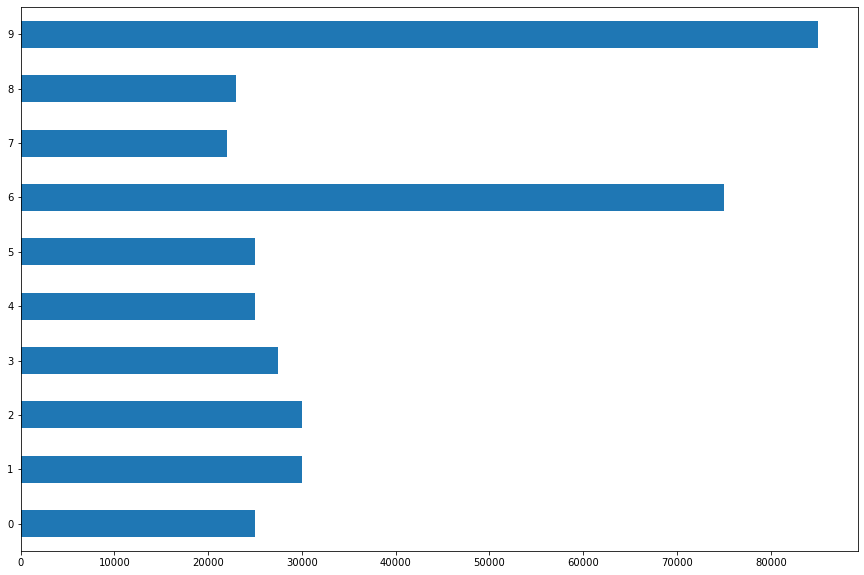

In [45]:
#Showing First 10 Normalized Salary from dataset
ms = dataset["SalaryNormalized"][:10].plot.barh(figsize=(15,10))

<AxesSubplot:>

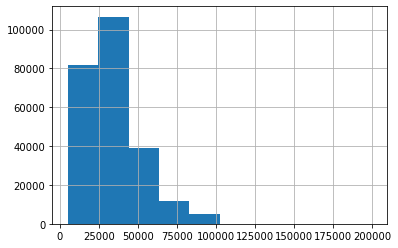

In [46]:
#hist graph based on Salary column
dataset["SalaryNormalized"].hist()

In [47]:
dataset["SalaryNormalized"].value_counts().sort_values(ascending=False)[:10]

35000    9178
30000    8319
40000    7688
45000    6735
25000    6309
32500    6215
37500    5756
27500    5544
50000    5424
42500    4555
Name: SalaryNormalized, dtype: int64

<AxesSubplot:>

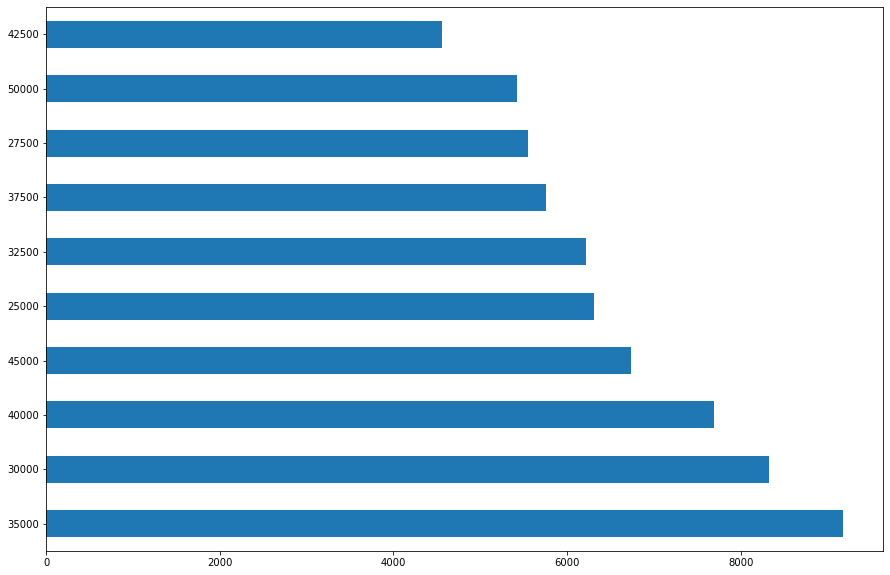

In [48]:
#Below Graph shows that Number of Employess vs salary (Top 10 Ssalaries)
#We can simplify that how many number of employees getting top 10 salaries and what is the amount
dataset["SalaryNormalized"].value_counts().sort_values(ascending=False)[:10].plot.barh(figsize=(15,10))

<AxesSubplot:ylabel='ContractTime'>

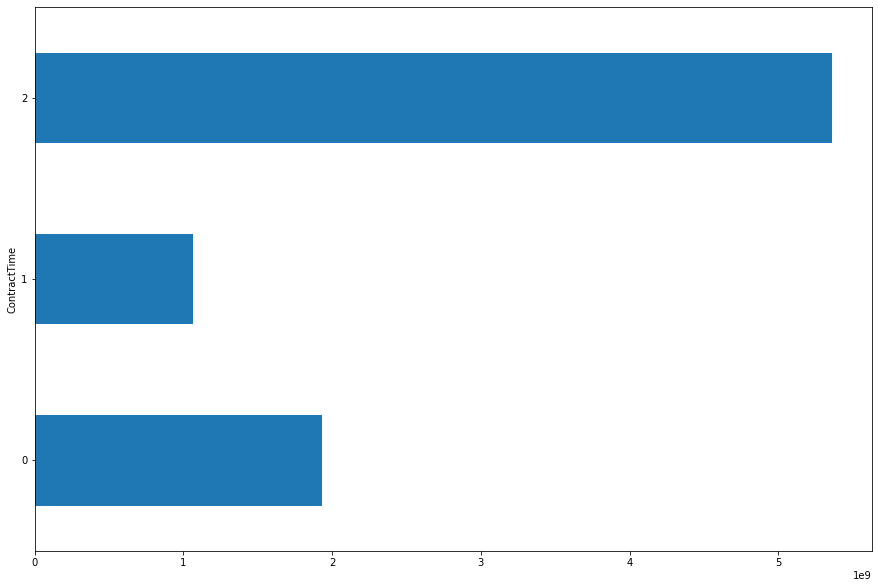

In [49]:
#Below Graph gives us the ContractTime types and paying to each type
dataset.groupby('ContractTime')['SalaryNormalized'].sum().plot.barh(figsize=(15,10))

<AxesSubplot:ylabel='ContractType'>

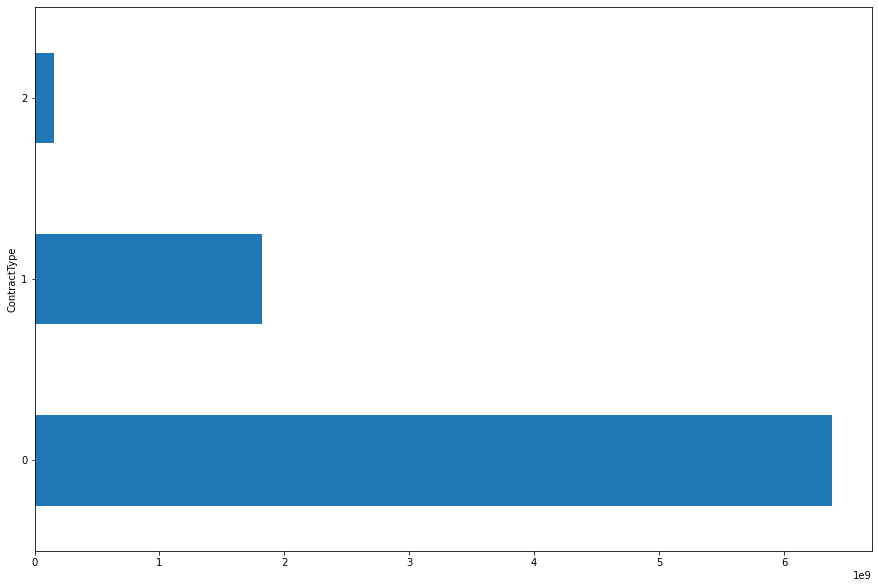

In [50]:
#Below graph gives us ContractType and paying to each type
dataset.groupby('ContractType')['SalaryNormalized'].sum().plot.barh(figsize=(15,10))

In [51]:
#preparing Input Columns and Target Columns to train our model
X_train = dataset.drop(['SalaryNormalized'],axis = 1)
y_train = dataset['SalaryNormalized']

In [52]:
#Below are Input Columns and their data
X_train

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SourceNameis_missing
0,12612628,39227,68301,5178,751,0,2,7758,9,43,False,False,False,False,True,False,False,False,False
1,12612830,121388,196351,6881,987,0,2,7758,9,43,False,False,False,False,True,False,False,False,False
2,12612844,73486,117824,7630,1069,0,2,7758,9,43,False,False,False,False,True,False,False,False,False
3,12613049,39228,68300,17183,2310,0,2,7758,9,43,False,False,False,False,True,False,False,False,False
4,12613647,85435,157839,17183,2310,0,2,7758,9,43,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,123566,159877,17363,2329,0,1,0,27,65,False,False,False,False,True,False,True,False,False
244764,72705212,123556,159879,17363,2329,0,1,0,27,65,False,False,False,False,True,False,True,False,False
244765,72705213,36446,159864,17363,2329,0,1,0,27,65,False,False,False,False,True,False,True,False,False
244766,72705216,103002,159865,19775,2643,0,1,0,27,65,False,False,False,False,True,False,True,False,False


In [53]:
#Output Columns
y_train

0         25000
1         30000
2         30000
3         27500
4         25000
          ...  
244763    22800
244764    22800
244765    22800
244766    22800
244767    42500
Name: SalaryNormalized, Length: 244768, dtype: int64

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
regressor = RandomForestRegressor(n_jobs = -1,random_state=42)

### Training Random Forest Model with Input and out data

In [56]:
%%time
regressor.fit(X_train,y_train)

Wall time: 1min 42s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [57]:
#Prediction Output of Trained Input
y_train_pred = regressor.predict(X_train)

##### Checking Mean Squared Error for out model

In [58]:
from sklearn.metrics import mean_squared_error

In [60]:
error = mean_squared_error(y_train_pred, y_train, squared=False)

In [61]:
error

4511.558606828981

In [62]:
#Checking Estimators of our Model
regressor.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=1608637542),
 DecisionTreeRegressor(max_features='auto', random_state=1273642419),
 DecisionTreeRegressor(max_features='auto', random_state=1935803228),
 DecisionTreeRegressor(max_features='auto', random_state=787846414),
 DecisionTreeRegressor(max_features='auto', random_state=996406378),
 DecisionTreeRegressor(max_features='auto', random_state=1201263687),
 DecisionTreeRegressor(max_features='auto', random_state=423734972),
 DecisionTreeRegressor(max_features='auto', random_state=415968276),
 DecisionTreeRegressor(max_features='auto', random_state=670094950),
 DecisionTreeRegressor(max_features='auto', random_state=1914837113),
 DecisionTreeRegressor(max_features='auto', random_state=669991378),
 DecisionTreeRegressor(max_features='auto', random_state=429389014),
 DecisionTreeRegressor(max_features='auto', random_state=249467210),
 DecisionTreeRegressor(max_features='auto', random_state=1972458954),
 DecisionTreeRegressor(max_f

In [63]:
from sklearn.tree import plot_tree, export_text
import seaborn as sns

[Text(1674.0, 713.475, 'SourceName <= 13.5\nmse = 311485399.271\nsamples = 154633\nvalue = 34167.243'),
 Text(837.0, 509.625, 'ContractTime <= 0.5\nmse = 197522984.294\nsamples = 18290\nvalue = 24290.587'),
 Text(418.5, 305.775, 'SourceName <= 8.5\nmse = 125096342.169\nsamples = 15526\nvalue = 21530.806'),
 Text(209.25, 101.92499999999995, '\n  (...)  \n'),
 Text(627.75, 101.92499999999995, '\n  (...)  \n'),
 Text(1255.5, 305.775, 'SourceName <= 6.0\nmse = 321396201.599\nsamples = 2764\nvalue = 39774.091'),
 Text(1046.25, 101.92499999999995, '\n  (...)  \n'),
 Text(1464.75, 101.92499999999995, '\n  (...)  \n'),
 Text(2511.0, 509.625, 'SourceName <= 45.0\nmse = 311938145.882\nsamples = 136343\nvalue = 35485.777'),
 Text(2092.5, 305.775, 'SourceName <= 36.5\nmse = 245549212.271\nsamples = 38224\nvalue = 32227.569'),
 Text(1883.25, 101.92499999999995, '\n  (...)  \n'),
 Text(2301.75, 101.92499999999995, '\n  (...)  \n'),
 Text(2929.5, 305.775, 'SourceName <= 158.5\nmse = 332076009.009\nsa

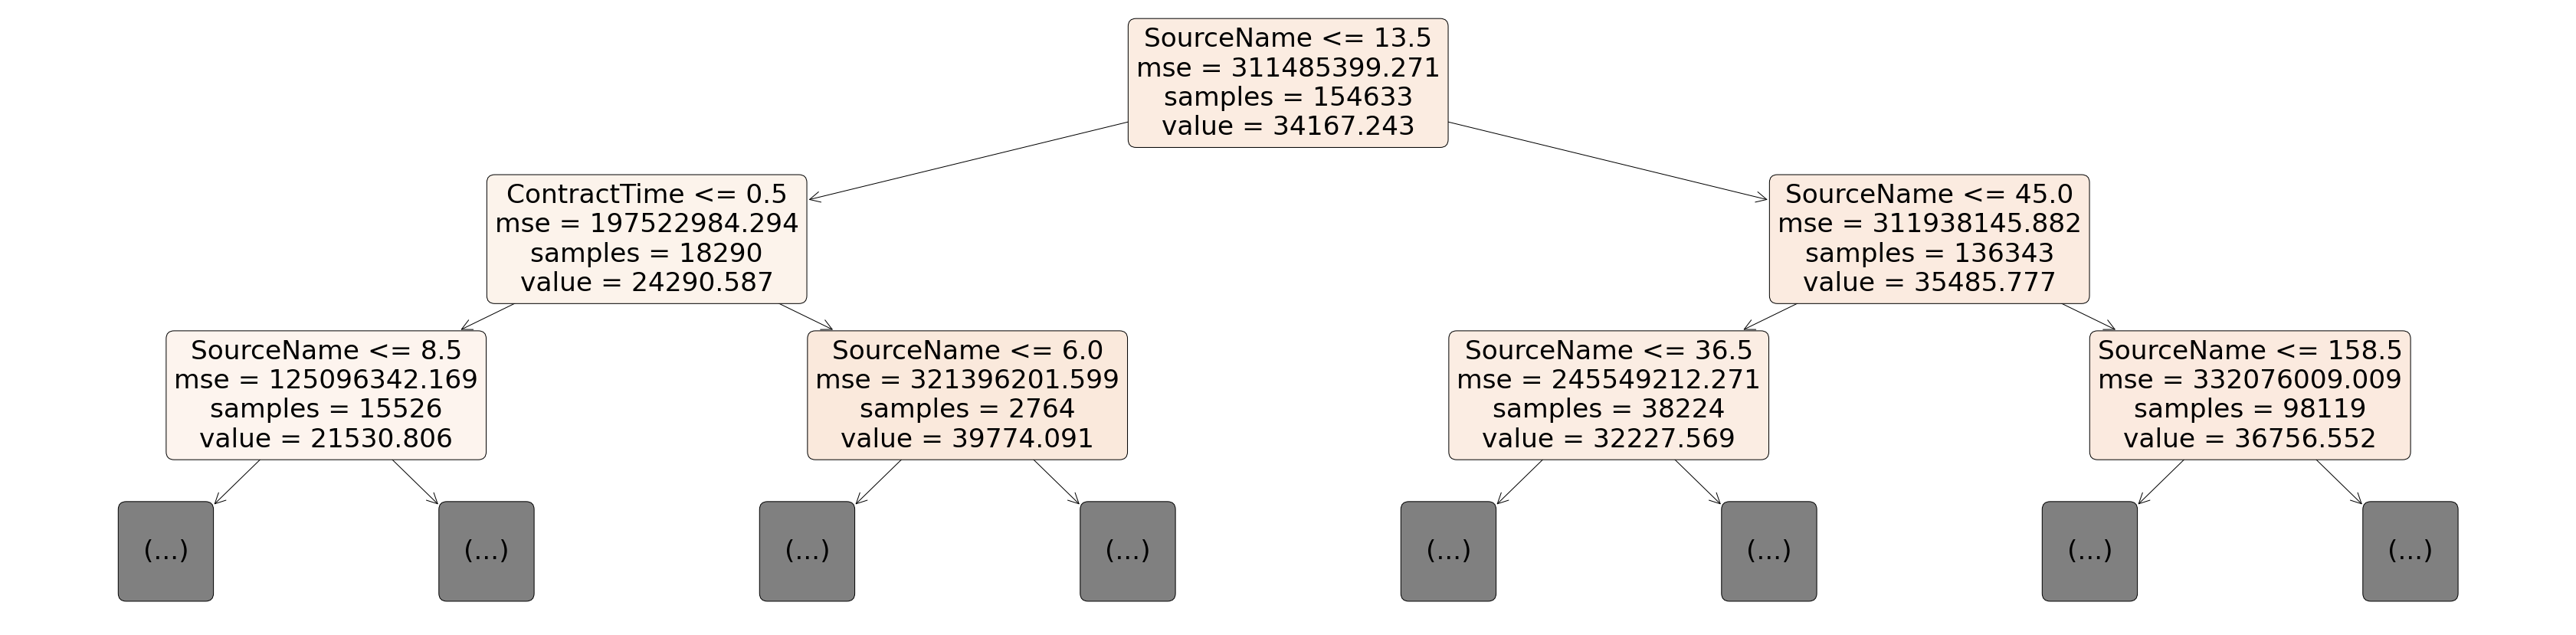

In [64]:
plt.figure(figsize=(60,15))

# Visualize the tree graphically using plot_tree
plot_tree(regressor.estimators_[0],feature_names=X_train.columns,max_depth=2,filled=True,rounded=True)

[Text(1674.0, 733.86, 'SourceName <= 13.5\nmse = 314487120.752\nsamples = 154713\nvalue = 34234.032'),
 Text(837.0, 570.78, 'SourceName <= 5.5\nmse = 201152132.122\nsamples = 18288\nvalue = 24402.486'),
 Text(418.5, 407.70000000000005, 'Category <= 20.5\nmse = 353446143.397\nsamples = 2003\nvalue = 43688.521'),
 Text(209.25, 244.62, 'Title <= 12288.0\nmse = 317074017.557\nsamples = 1914\nvalue = 45123.503'),
 Text(104.625, 81.54000000000008, '\n  (...)  \n'),
 Text(313.875, 81.54000000000008, '\n  (...)  \n'),
 Text(627.75, 244.62, 'Id <= 69671512.0\nmse = 59315737.719\nsamples = 89\nvalue = 10826.336'),
 Text(523.125, 81.54000000000008, '\n  (...)  \n'),
 Text(732.375, 81.54000000000008, '\n  (...)  \n'),
 Text(1255.5, 407.70000000000005, 'SourceName <= 8.5\nmse = 132018941.046\nsamples = 16285\nvalue = 22060.909'),
 Text(1046.25, 244.62, 'ContractType <= 1.5\nmse = 102293318.935\nsamples = 11364\nvalue = 19676.763'),
 Text(941.625, 81.54000000000008, '\n  (...)  \n'),
 Text(1150.875,

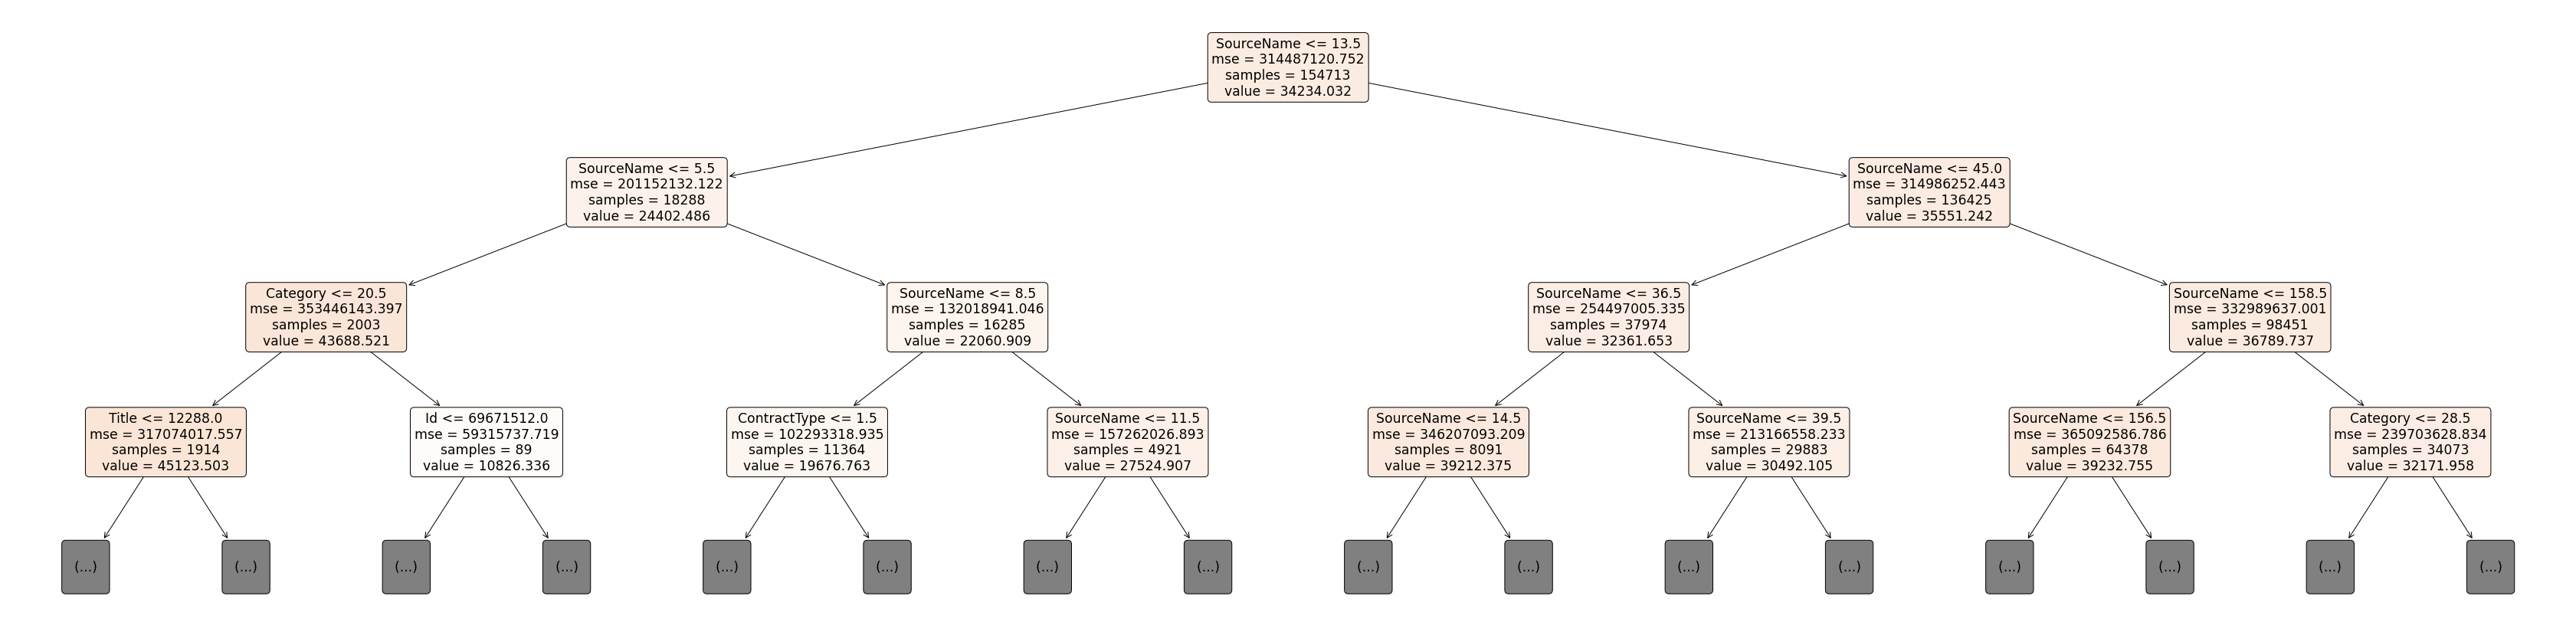

In [216]:
plt.figure(figsize=(60,15))

# Visualize the tree graphically using plot_tree
plot_tree(regressor.estimators_[20],feature_names=X_train.columns,max_depth=3,filled=True,rounded=True)

In [65]:
#Below are importances for each input columns
regressor.feature_importances_

array([1.08076255e-01, 2.04877935e-01, 1.15170118e-01, 7.59461165e-02,
       6.08672798e-02, 8.52700213e-03, 3.90351785e-02, 9.52089869e-02,
       1.21489395e-01, 1.52175212e-01, 4.39748410e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.52395303e-03, 1.28812166e-02,
       2.18336053e-03, 0.00000000e+00, 3.75513099e-05])

In [66]:
#To check which importance against each feature
tree_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False)

In [67]:
tree_importance_df.sort_values(by='importance',ascending=False)

,feature,importance
1,Title,2.048779e-01
9,SourceName,1.521752e-01
8,Category,1.214894e-01
2,FullDescription,1.151701e-01
0,Id,1.080763e-01
7,Company,9.520899e-02
3,LocationRaw,7.594612e-02
4,LocationNormalized,6.086728e-02
6,ContractTime,3.903518e-02
15,ContractTimeis_missing,1.288122e-02


In [68]:
#Displaying top 10 features
tree_importance_df.sort_values(by='importance',ascending=False)[:10]

,feature,importance
1,Title,0.204878
9,SourceName,0.152175
8,Category,0.121489
2,FullDescription,0.115170
0,Id,0.108076
7,Company,0.095209
3,LocationRaw,0.075946
4,LocationNormalized,0.060867
6,ContractTime,0.039035
15,ContractTimeis_missing,0.012881


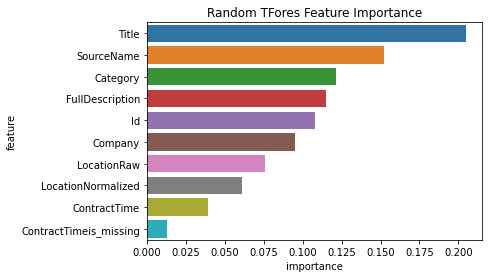

In [69]:
#Displaying top 10 features in bragraph
plt.title('Random TFores Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

#### Loading Validation Dataset

In [71]:
val_dataset = pd.read_csv('./job-salary-prediction/Valid_rev1.csv')

In [72]:
val_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40663 entries, 0 to 40662
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  40663 non-null  int64 
 1   Title               40663 non-null  object
 2   FullDescription     40663 non-null  object
 3   LocationRaw         40663 non-null  object
 4   LocationNormalized  40663 non-null  object
 5   ContractType        10968 non-null  object
 6   ContractTime        30181 non-null  object
 7   Company             35312 non-null  object
 8   Category            40663 non-null  object
 9   SourceName          40663 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.1+ MB


In [73]:
val_dataset.isna().sum()

Id                        0
Title                     0
FullDescription           0
LocationRaw               0
LocationNormalized        0
ContractType          29695
ContractTime          10482
Company                5351
Category                  0
SourceName                0
dtype: int64

In [74]:
string_cols = ['Title', 'FullDescription', 'LocationRaw', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName']

In [75]:
val_dataset[string_cols] = val_dataset[string_cols].astype('category')

In [76]:
for label,content in val_dataset.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        val_dataset[label+"is_missing"]=pd.isnull(content)
        # Turn categories into numbers and add+1
        val_dataset[label] = pd.Categorical(content).codes+1

In [77]:
val_dataset.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SourceNameis_missing
0,13656201,14498,18559,3627,844,0,2,7192,14,93,False,False,False,False,True,False,False,False,False
1,14663195,20825,33455,3338,794,0,2,1941,11,40,False,False,False,False,True,False,False,False,False
2,16530664,15788,19787,2736,612,0,2,3423,9,40,False,False,False,False,True,False,False,False,False
3,19047458,28826,4742,6770,1468,0,2,1274,1,40,False,False,False,False,True,False,False,False,False
4,20881907,16304,4743,2005,465,0,2,1274,1,40,False,False,False,False,True,False,False,False,False


In [78]:
val_dataset.isna().sum()

Id                              0
Title                           0
FullDescription                 0
LocationRaw                     0
LocationNormalized              0
ContractType                    0
ContractTime                    0
Company                         0
Category                        0
SourceName                      0
Titleis_missing                 0
FullDescriptionis_missing       0
LocationRawis_missing           0
LocationNormalizedis_missing    0
ContractTypeis_missing          0
ContractTimeis_missing          0
Companyis_missing               0
Categoryis_missing              0
SourceNameis_missing            0
dtype: int64

In [80]:
val_dataset.columns

Index(['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized',
       'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName',
       'Titleis_missing', 'FullDescriptionis_missing', 'LocationRawis_missing',
       'LocationNormalizedis_missing', 'ContractTypeis_missing',
       'ContractTimeis_missing', 'Companyis_missing', 'Categoryis_missing',
       'SourceNameis_missing'],
      dtype='object')

#### Prediting Validation dataset values

In [82]:
y_val_pred = regressor.predict(val_dataset)

In [83]:
y_val_act = pd.read_csv('./job-salary-prediction/mean_benchmark.csv')

In [84]:
y_val_act1 = y_val_act.iloc[:,-1]

In [85]:
y_val_act1.ravel()

array([33084.31835452, 33084.31835452, 33084.31835452, ...,
       33084.31835452, 33084.31835452, 33084.31835452])

In [86]:
error = mean_squared_error(y_val_pred, y_val_act1, squared=False)

In [87]:
error

9453.6886057585

### Checking same data with LinearRegression Model

In [90]:
from sklearn.linear_model import LinearRegression

In [91]:
regressor1 = LinearRegression()

In [92]:
regressor1.fit(X_train,y_train)

LinearRegression()

In [93]:
#Predicting Target values of trained inputs
y_train_pred = regressor1.predict(X_train)

In [99]:
#Checking error
error = mean_squared_error(y_train_pred, y_train, squared=False)

In [100]:
error

17157.133232827055

In [101]:
#Predicting Validation dataset 
y_val_pred = regressor1.predict(val_dataset)

In [102]:
error = mean_squared_error(y_val_pred, y_val_act1, squared=False)

In [103]:
error

3925.7939966543763

## Hyper Parameter tuning using RandomizedSearchCV

In [104]:
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)
grid = {
    "n_estimators":np.arange(10,100,10),
    "max_depth":[None,3,5,10],
    "min_samples_split":np.arange(2,20,2),
    "min_samples_leaf":np.arange(1,20,2),
    "max_features": [0.5,1,"sqrt","auto"],
    "max_samples":[10000,12000,15000,20000]
}
rs_model = RandomizedSearchCV(
RandomForestRegressor(n_jobs=-1,
                     random_state=42),
                     param_distributions = grid,
                     n_iter=5,
                     cv=5,
                    verbose=True)
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000, 12000, 15000,
                                                        20000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [105]:
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 6,
 'min_samples_leaf': 19,
 'max_samples': 12000,
 'max_features': 'auto',
 'max_depth': None}

In [106]:
y_train_pred = rs_model.predict(X_train)

In [107]:
error = mean_squared_error(y_train_pred, y_train, squared=False)
error

14028.128210758618

In [108]:
y_val_pred = rs_model.predict(val_dataset)

In [109]:
error = mean_squared_error(y_val_pred, y_val_act1, squared=False)
error

6641.831013593221

## Predicting Test Data set Results

In [111]:
test_dataset = pd.read_csv('./job-salary-prediction/Test_rev1/Test_rev1.csv')

In [112]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122463 entries, 0 to 122462
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  122463 non-null  int64 
 1   Title               122463 non-null  object
 2   FullDescription     122463 non-null  object
 3   LocationRaw         122463 non-null  object
 4   LocationNormalized  122463 non-null  object
 5   ContractType        33013 non-null   object
 6   ContractTime        90702 non-null   object
 7   Company             106202 non-null  object
 8   Category            122463 non-null  object
 9   SourceName          122463 non-null  object
dtypes: int64(1), object(9)
memory usage: 9.3+ MB


In [113]:
test_dataset.isna().sum()

Id                        0
Title                     0
FullDescription           0
LocationRaw               0
LocationNormalized        0
ContractType          89450
ContractTime          31761
Company               16261
Category                  0
SourceName                0
dtype: int64

In [114]:
test_dataset[string_cols] = test_dataset[string_cols].astype('category')

In [115]:
for label,content in test_dataset.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        test_dataset[label+"is_missing"]=pd.isnull(content)
        # Turn categories into numbers and add+1
        test_dataset[label] = pd.Categorical(content).codes+1

In [116]:
test_dataset.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SourceNameis_missing
0,11888454,8021,103161,11935,1338,0,2,1149,27,43,False,False,False,False,True,False,False,False,False
1,11988350,34797,103093,11949,1338,0,2,1149,4,43,False,False,False,False,True,False,False,False,False
2,12612558,22566,34355,11410,1819,0,2,5733,9,43,False,False,False,False,True,False,False,False,False
3,12613014,10037,22622,1597,283,0,2,5733,9,43,False,False,False,False,True,False,False,False,False
4,22454872,10239,22775,4447,743,0,2,5733,18,43,False,False,False,False,True,False,False,False,False


In [118]:
X_test = test_dataset.copy()

In [119]:
X_test

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,Titleis_missing,FullDescriptionis_missing,LocationRawis_missing,LocationNormalizedis_missing,ContractTypeis_missing,ContractTimeis_missing,Companyis_missing,Categoryis_missing,SourceNameis_missing
0,11888454,8021,103161,11935,1338,0,2,1149,27,43,False,False,False,False,True,False,False,False,False
1,11988350,34797,103093,11949,1338,0,2,1149,4,43,False,False,False,False,True,False,False,False,False
2,12612558,22566,34355,11410,1819,0,2,5733,9,43,False,False,False,False,True,False,False,False,False
3,12613014,10037,22622,1597,283,0,2,5733,9,43,False,False,False,False,True,False,False,False,False
4,22454872,10239,22775,4447,743,0,2,5733,18,43,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122458,72703426,25895,31073,13430,2115,1,2,13913,29,95,False,False,False,False,False,False,False,False,False
122459,72703453,62280,92917,1116,198,1,2,146,29,95,False,False,False,False,False,False,False,False,False
122460,72705210,71299,80786,11524,1834,0,1,0,27,64,False,False,False,False,True,False,True,False,False
122461,72705214,77104,42361,2128,371,0,1,0,27,64,False,False,False,False,True,False,True,False,False


In [120]:
y_test_pred = regressor.predict(X_test)

In [121]:
y_test_pred

array([27563.72, 38811.1 , 41121.95, ..., 28328.79, 26400.26, 27856.25])

In [124]:
X_test.iloc[:,0].ravel()

array([11888454, 11988350, 12612558, ..., 72705210, 72705214, 72705218],
      dtype=int64)

array([[27563.72],
       [38811.1 ],
       [41121.95],
       ...,
       [28328.79],
       [26400.26],
       [27856.25]])

In [131]:
Test_results = pd.DataFrame({'Id': X_test.iloc[:,0], 'SalaryNormalized':y_test_pred})

In [133]:
Test_results.to_csv('test_results_submissions.csv', index=False)